In [1]:
from sklearn.ensemble import IsolationForest

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import shap

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../Dataset')
data = pd.read_pickle('../smart_app_data.pkl')

In [3]:
def detect_trend_drift_recursive(time_series, selected_f, n = 4):
    """
    Detects trend drift by comparing the current distribution with the seasonality pattern.
    Uses statistical tests to evaluate changes in the data.

    Parameters:
    - time_series: Pandas Series with the KPI time series data.
    - selected_f: Selected seasonality frequency.
    - n: Number of iterations for trend drift detection.
    Returns:
    - trend_drift_flag: Boolean indicating if a trend drift is detected.
    """
    trend_drift_bool = False
    ks_stat = 0

        # Check if time_series is long enough for comparison
    if len(time_series) > 2*selected_f:
      i = 0
      while i < n and not trend_drift_bool:
        # Perform a Kolmogorov-Smirnov test to compare distributions
        if len(time_series) > (2+i)*selected_f:
          seasonal_values = time_series[-(2+i)*selected_f:-(1+i)*selected_f]
          ks_stat, p_value = ks_2samp(time_series[-selected_f:], seasonal_values)
          #print(f"ks_stat: {ks_stat}")
          #print(f"p_value: {p_value}")
          if p_value < 0.05:  # Threshold for detecting drift
            print("Trend drift detected!")
            trend_drift_bool = True
            # understanding in which direction there is a trend drift in the distribution
            if seasonal_values.mean() < time_series[-selected_f:].mean():
              print("Trend drift is positive")
              # send_warning('Positive_trend_drift', f'Trend drift is positive')
              ks_stat = - ks_stat
            else:
              print("Trend drift is negative")
              # send_warning('Negative_trend_drift', f'Trend drift is negative')
              ks_stat = - ks_stat
        i = i + 1

    return trend_drift_bool, ks_stat

# comment
# KS test works well with at least 30 samples, so remember that the dection that we find is not really reliable but can be adequate for just an alert, as we are planning to do.

In [4]:
def detect_inconsistencies_exogenous(time_series, exogenous_lower_thr=None, exogenous_higher_thr=None): # note: the threshold should be conservative already
    """
    Detect inconsistencies based on exogenous thresholds.

    Parameters:
    - time_series: Pandas Series with the KPI time series data
    - exogenous_lower_thr: Lower threshold for detection (optional).
    - exogenous_higher_thr: Higher threshold for detection (optional).

    Returns:
    - inconsistencies_flag: 1 if inconsistencies are detected, 0 otherwise.
    """
    inconsistencies_flag = np.zeros(len(time_series))
    for i in range(len(time_series)):
      # Check for inconsistencies using quartiles and thresholds
      inconsistent = (
          (exogenous_lower_thr is not None and time_series.iloc[i] < exogenous_lower_thr) or
          (exogenous_higher_thr is not None and time_series.iloc[i] > exogenous_higher_thr)
      )

      if inconsistent:
          inconsistencies_flag[i] = 1
          # send_warning('Ex_inconsistency', f'Found inconsistency at index {i}')

    return inconsistencies_flag

In [5]:
def historical_concept_drift(time_series, selected_f, n = 4):
  trend_drift_h = pd.DataFrame({
      "trend_drift_bool": [None] * len(time_series),  # Initialize with None or False
      "ks_stat": [np.nan] * len(time_series)          # Initialize with NaN
  })
  for i in range(len(time_series)):
    h_time_series = time_series[:i]
    trend_drift_h.loc[i,"trend_drift_bool"], trend_drift_h.loc[i,"ks_stat"] = detect_trend_drift_recursive(h_time_series, selected_f, n)
  return trend_drift_h

In [6]:
def handle_missing_values(time_series, card_imputation = 5):
    """
    Handle missing values in a Pandas Series. If the missing ratio exceeds 15%,
    replaces all values with "NaN". Otherwise, fills missing values with
    the mean of the previous 5 valid values.

    Parameters:
    - time_series: Pandas Series with the KPI time series data.
    - card_imputation: Number of previous values used for imputation

    Returns:
    - Updated time_series: Series with missing values handled.
    """

    # Calculate the percentage of missing values
    missing_ratio = time_series.isnull().sum() / len(time_series)
    unusable_data_bool = False

    if missing_ratio > 0.15:
        print(f'The time series has more than 15% of missing values. Replaced with "NaN".')
        time_series[:] = np.nan
        unusable_data_bool = True
    else:
        # Handle each missing value individually
        for i in time_series.index:
            if pd.isnull(time_series.at[i]):
                print(f'Found missing value at index {i}.')

                # Get the last 5 valid values before the current index
                recent_values = time_series[:i].dropna().tail(card_imputation)

                if len(recent_values) > 0:  # Ensure there are enough valid values
                    mean_value = recent_values.mean()
                    time_series.at[i] = mean_value
                else:
                    print(f'Not enough data to calculate the mean for the missing value at index {i}.')

    return unusable_data_bool, time_series

In [7]:
def analysis_seasonality(time_series, freq = [7, 30], plot_flag = None):
    """
    Analyzes the seasonality of a time series for a specific machine and KPI.
    Parameters:
    - time_series: Pandas Series with the KPI time series data.
    - freq: List of seasonality frequencies to analyze.
    - plot_flag: Flag to decide whether to plot the results.

    Returns:
    - best_decomposition: Best seasonal decomposition object.
    - selected_f: Selected seasonality frequency.
    """

    # Set time as the index
    time_series = time_series.values

    # Compute the total series variance
    total_variance = np.var(time_series)

    # cycle for different seasonality freq
    best_seas_contribuition = 0
    best_decomposition = None
    selected_f = None

    for f in freq:

      # Check if there is enough data
      if len(time_series) < f:
        print(f"Not enough data to analyze seasonality (at least {f} points are required).")
      else:
        # Perform seasonal decomposition
        decomposition = seasonal_decompose(time_series, model='additive', period=f)

        # Compute the seasonal contribution
        if total_variance == 0:
          seas_contribuition = 0
        else:
          seas_contribuition = np.var(decomposition.seasonal) / total_variance
        if seas_contribuition >= best_seas_contribuition:
          selected_f = f
          best_decomposition = decomposition
          best_seas_contribuition = seas_contribuition

    # print(f"Best selected seasonality is: {selected_f}")
    # Plot the results
    if plot_flag == True:
      best_decomposition.plot()
      plt.suptitle(f'Additive Model - Seasonality for {selected_f}', fontsize=12, y=1.02)
      plt.show()

    return best_decomposition, selected_f

# Multiplicative Model cannot be implemented if there are zeros in the data.
# One can possibly add a bias to the series, apply a log transformation or eventually filter out zero data but this can
# induce possible misinterpretations--> Hockam's razor


In [8]:
# HISTORICAL DATA PREPROCESSING
def preprocess_h_data(time_series, ex_lower_thr=None, ex_higher_thr=None):

    best_decomposition, selected_f, inconsistencies_flag, h_trend_drift = None, None, None, None

    # Handling missing data and raise warning
    unusable_data_bool, time_series = handle_missing_values(time_series)

    if not unusable_data_bool:

      # seasonality analysis
      best_decomposition, selected_f = analysis_seasonality(time_series)

      # statistical analysis to extract data_parameters
      #data_parameters = perform_stat_analysis(time_series)

      # detect inconsistencies in the numerical values with respect to an exogenous threshold -> anomalies/spike
      inconsistencies_flag = detect_inconsistencies_exogenous(time_series, ex_lower_thr, ex_higher_thr)

      # detect trend drift
      h_trend_drift = historical_concept_drift(time_series, selected_f)

    return best_decomposition, selected_f, inconsistencies_flag, h_trend_drift, time_series #data_parameters

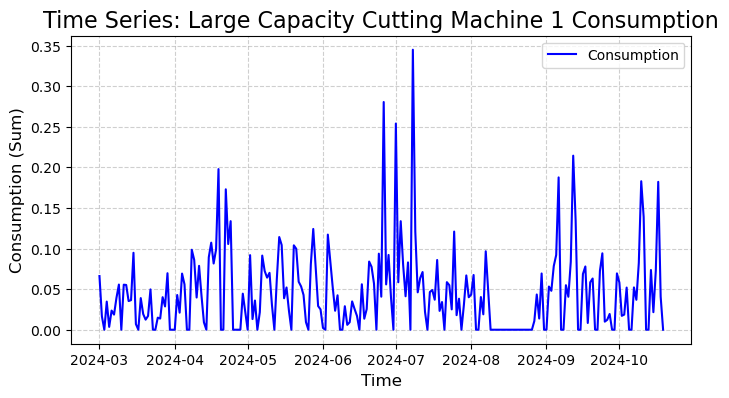

In [9]:
# Filter the time series
time_series = data.loc[
    (data['name'] == 'Large Capacity Cutting Machine 1') &
    (data['kpi'] == 'consumption'),
    ['time', 'sum']
]

# Make sure that the 'time' column is in datetime format
time_series['time'] = pd.to_datetime(time_series['time'])

# Set the 'time' column as the index
time_series.set_index('time', inplace=True)

# Convert 'sum' to numeric values if necessary
time_series['sum'] = pd.to_numeric(time_series['sum'], errors='coerce')

# Set frequency to daily
time_series = time_series.asfreq('D')

# Plot of the time series
plt.figure(figsize=(8, 4))
plt.plot(time_series.index, time_series['sum'], label='Consumption', color='blue', linewidth=1.5)
plt.title('Time Series: Large Capacity Cutting Machine 1 Consumption', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Consumption (Sum)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [10]:
# preprocess the time series to obtain the best_decomposition
best_decomposition, selected_f, inconsistencies_flag, h_trend_drift, time_series = preprocess_h_data(time_series['sum'])

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Trend drift detected!
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift detected!
Trend drift is positive
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative
Trend drift detected!
Trend drift is negative


In [11]:
residuals = pd.Series(best_decomposition.resid).dropna()#.reset_index(drop=True)
residuals.index += 1  # Start indices from 1
residual_df = pd.DataFrame({'residuals': residuals})

In [15]:
iso_forest = IsolationForest(random_state=1)  # Random state for reproducibility

In [17]:
residual_df['residuals'].shape

(227,)

In [22]:
X, y = shap.datasets.california()

X.iloc[[0],:]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23


In [16]:
# iso_forest.fit(residual_df[['residuals']])

explainer = shap.TreeExplainer(iso_forest)
test = residual_df.iloc[[0],:]
score = iso_forest.score_samples(test)

shap_explained = explainer.shap_values(test).sum()+explainer.expected_value

AttributeError: 'IsolationForest' object has no attribute 'estimators_'

In [ ]:
residual_df['anomaly'] = iso_forest.predict(residual_df[['residuals']])
residual_df['anomaly'] = residual_df['anomaly'].map({1: 0, -1: 1})  # Map 1 to anomaly, 0 to normal
# Extract anomalies
anomalies = residual_df[residual_df['anomaly'] == 1]['residuals']
anomaly_indices = anomalies.index
# Plot anomalies if requested
if True:
    plt.figure(figsize=(8, 4))
    plt.plot(residual_df.index, residual_df['residuals'], label='Residuals', color='blue')
    plt.scatter(
        anomaly_indices,
        residual_df.loc[anomaly_indices, 'residuals'],
        color='red', label='Anomalies', zorder=5
    )
    plt.title("Anomaly Detection Based on Residuals")
    plt.xlabel("Index")
    plt.ylabel("Residual Value")
    plt.legend()
    plt.show()

In [ ]:
test = residual_df.iloc[0:1, :]  # Slice the DataFrame to ensure a 2D array

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value, shap_explained)